In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
from particles.mcmc import PMMH

In [3]:
class CrealCountModel(ssm.StateSpaceModel):
    """
    Modèle de comptage (Section 5.1) compatible avec 'particles'.
    """
    # On définit les clés par défaut
    default_params = {'phi': 0.95, 'nu': 1.5, 'c': 1.0, 'beta': np.array([0.0])}

    def __init__(self, X=None, **kwargs):
        super().__init__(**kwargs) # Appelle l'init parent pour stocker phi, nu, c...
        if X is not None:
            self.X = np.asarray(X)
        else:
            self.X = None

    def PX0(self):
        return dists.Gamma(a=self.nu, b=self.c * (1.0 - self.phi))

    def PX(self, t, xp):
        # Transition du processus latent (inchangée)
        rate_z = self.phi * self.c * xp
        z = np.random.poisson(rate_z)
        return dists.Gamma(a=self.nu + z, b=self.c)

    def PY(self, t, xp, x):
        # Observation avec Covariables
        multiplier = 1.0
        if self.X is not None and hasattr(self, 'beta'):
            # Calcul du terme exp(X_t * beta)
            # On gère le cas où beta est scalaire ou vecteur
            b = np.asarray(self.beta)
            Xt = self.X[t]
            multiplier = np.exp(np.dot(Xt, b))
            
        # x est le vecteur de particules (latentes)
        # On retourne une loi de Poisson dont le taux est modulé
        return dists.Poisson(rate=x * multiplier)

In [4]:
# 1."Vrais Paramètres"
true_params = {
    'phi': 0.95,
    'nu': 1.5,
    'c': 1.0,
    'beta': np.array([0.5, -0.2]) # Exemple avec 2 covariables
}

# 2. On génère les covariables X et les données y selon cette Vérité
T = 200
X_cov = np.random.randn(T, 2) # Covariables artificielles
my_model_truth = CrealCountModel(X=X_cov, **true_params) # On instancie avec la Vérité
_, y_obs = my_model_truth.simulate(T) # On crée les données y_obs

In [5]:
# 1. On définit ce qu'on sait A PRIORI (Le Prior)
# Attention : Doit matcher la dimension de X (ici 2 colonnes)
prior = dists.StructDist({
    'phi': dists.Uniform(0.0, 0.99),
    'nu':  dists.Gamma(2.0, 1.0),
    'c':   dists.Gamma(2.0, 1.0),
    'beta': dists.MvNormal(loc=np.zeros(2), cov=np.eye(2)) 
})

# 2. On choisit un point de départ
# Etape technique : On génère un conteneur valide
theta_start = prior.rvs(size=1) 

# Etape stratégique : On initialise dans une zone "sûre" pour aider le démarrage
theta_start['phi'] = 0.5  
theta_start['nu'] = 2.0
theta_start['c'] = 1.0
theta_start['beta'] = np.zeros(2) # On commence en supposant que X n'a pas d'effet

In [6]:
class CrealCountModelFixedX(CrealCountModel):
    def __init__(self, **kwargs):
        # On appelle le parent en lui forçant la variable X=X_cov
        # X_cov doit être défini dans votre notebook (ce que vous avez fait plus haut)
        super().__init__(X=X_cov, **kwargs)

In [11]:
%time

n_iter = 5000

print("Lancement PMMH avec N=200 particules (Low N)...")
pmmh_low = PMMH(
    niter=n_iter,       
    ssm_cls=CrealCountModelFixedX,   # Nouvelle classe
    data=y_obs,
    prior=prior,
    Nx=200,                     # Peu de particules (Bruit, Sticking)
    theta0=theta_start,   
    verbose=500
)
pmmh_low.run()

print("\nLancement PMMH avec N=1500 particules (High N)...")
pmmh_high = PMMH(
    niter=n_iter,
    ssm_cls=CrealCountModelFixedX,   # Nouvelle classe
    data=y_obs,
    prior=prior,
    Nx=1500,                    # Beaucoup de particules (Précis)
    theta0=theta_start,   
    verbose=500
)
pmmh_high.run()

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.87 μs
Lancement PMMH avec N=200 particules (Low N)...
Iteration 0, beta=[ 0.50088047 -0.14504239], c=2.534675858876755, nu=3.1432862109106634, phi=0.9526943497177709
Iteration 10, acc. rate=0.000, beta=[ 0.50088047 -0.14504239], c=2.534675858876755, nu=3.1432862109106634, phi=0.9526943497177709
Iteration 20, acc. rate=0.050, beta=[ 0.49601585 -0.16381306], c=2.44023728201929, nu=3.1116129145266878, phi=0.9512603307774942
Iteration 30, acc. rate=0.067, beta=[ 0.51162355 -0.15471724], c=2.4908280380156222, nu=3.149060379511887, phi=0.9789499591433957
Iteration 40, acc. rate=0.100, beta=[ 0.47468237 -0.17984884], c=2.444694387585333, nu=3.1313939487584332, phi=0.9838694391556334
Iteration 50, acc. rate=0.120, beta=[ 0.463847   -0.16834907], c=2.4460223016534455, nu=3.1185413596171956, phi=0.9732031832201415
Iteration 60, acc. rate=0.133, beta=[ 0.47269899 -0.16479041], c=2.4469326139302567, nu=3.1228938243607773, phi=0.985044575853

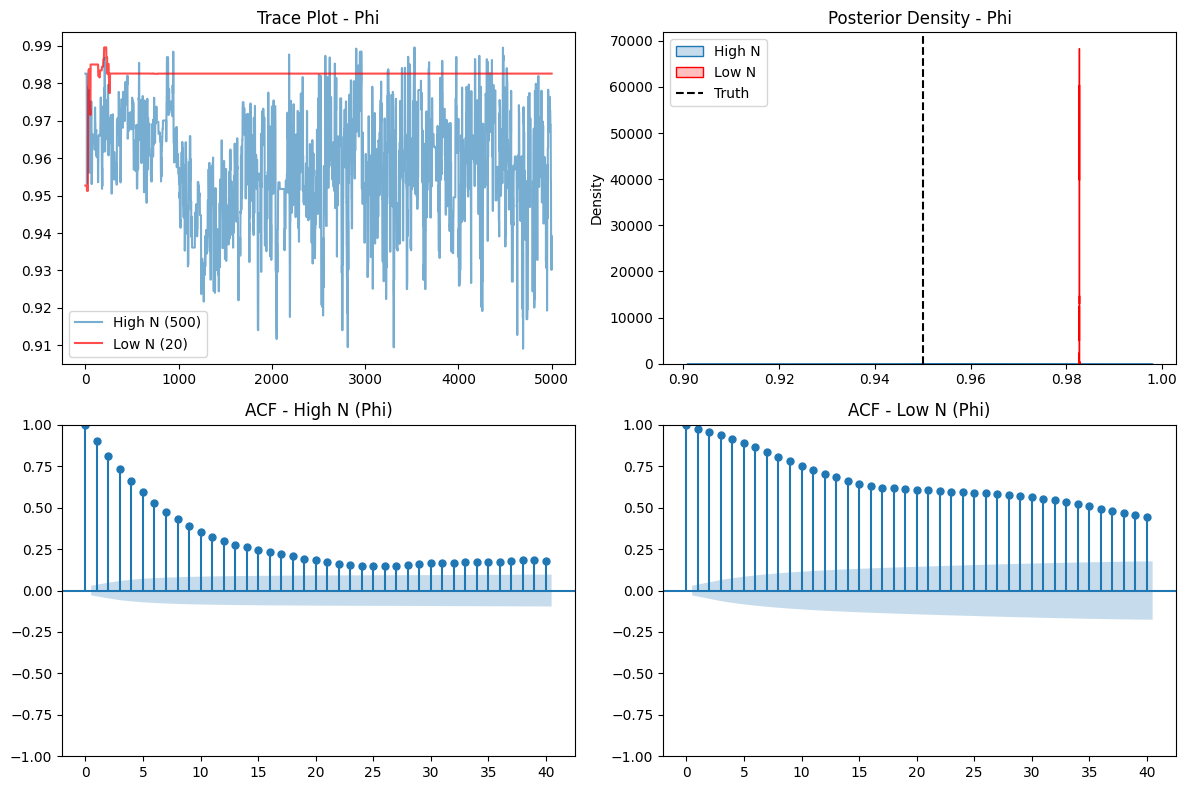

In [12]:
# Extraction des chaînes pour PHI
chain_low_phi = pmmh_low.chain.theta['phi']
chain_high_phi = pmmh_high.chain.theta['phi']

# Burn-in (on ignore les 500 premières itérations pour les plots)
burnin = 500

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- 1. Trace Plot ---
axes[0,0].plot(chain_high_phi, label='High N (500)', alpha=0.6)
axes[0,0].plot(chain_low_phi, label='Low N (20)', alpha=0.7, color='red')
axes[0,0].set_title("Trace Plot - Phi")
axes[0,0].legend()

# --- 2. Posterior Density ---
sns.kdeplot(chain_high_phi[burnin:], ax=axes[0,1], label='High N', fill=True)
sns.kdeplot(chain_low_phi[burnin:], ax=axes[0,1], label='Low N', color='red', fill=True)

# Ligne verticale pour la vraie valeur (assurez-vous que true_params existe)
if 'true_params' in locals():
    axes[0,1].axvline(true_params['phi'], color='k', linestyle='--', label='Truth')
    
axes[0,1].set_title("Posterior Density - Phi")
axes[0,1].legend()

# --- 3. ACF (Autocorrelation) ---
# Note : plot_acf gère mal les titres directement dans certaines versions, 
# on set le title sur l'axe
plot_acf(chain_high_phi[burnin:], ax=axes[1,0], lags=40)
axes[1,0].set_title("ACF - High N (Phi)")

plot_acf(chain_low_phi[burnin:], ax=axes[1,1], lags=40)
axes[1,1].set_title("ACF - Low N (Phi)")

plt.tight_layout()
plt.show()

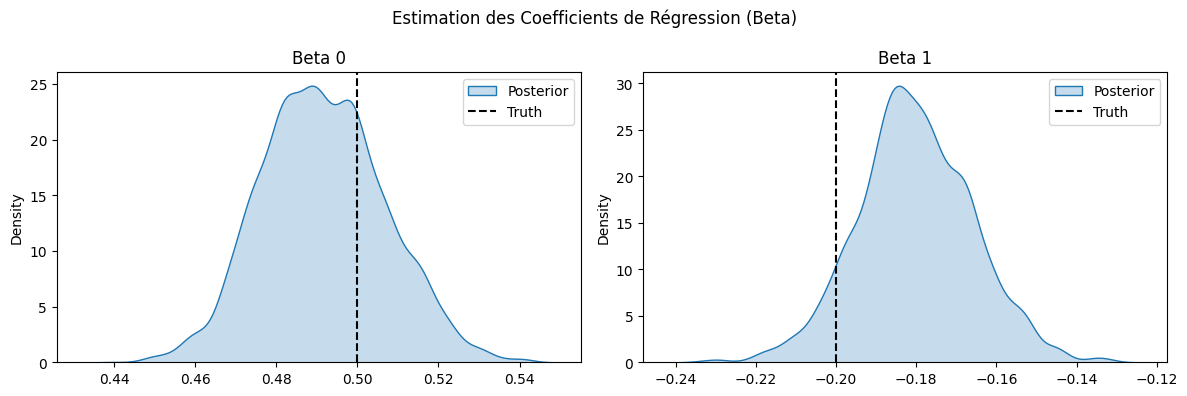

In [13]:
# Extraction des Betas (High N seulement)
# chain.theta['beta'] est une matrice de taille (niter, K)
betas_est = pmmh_high.chain.theta['beta'] 
K = betas_est.shape[1]

fig, axes = plt.subplots(1, K, figsize=(12, 4))
if K == 1: axes = [axes] # Gestion cas K=1

for k in range(K):
    sns.kdeplot(betas_est[burnin:, k], ax=axes[k], fill=True, label='Posterior')
    if 'true_params' in locals():
        axes[k].axvline(true_params['beta'][k], color='k', linestyle='--', label='Truth')
    axes[k].set_title(f"Beta {k}")
    axes[k].legend()

plt.suptitle("Estimation des Coefficients de Régression (Beta)")
plt.tight_layout()
plt.show()